# Standard Imports

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow is using GPU acceleration
print("TensorFlow GPU Enabled:", tf.test.is_built_with_cuda())
print("TensorFlow GPU Device:", tf.test.gpu_device_name())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU Enabled: True
TensorFlow GPU Device: /device:GPU:0


## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

# Data Parsing
parse_dates = True because we are dealing with time series data

In [2]:
df = pd.read_csv('./Data/RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [3]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


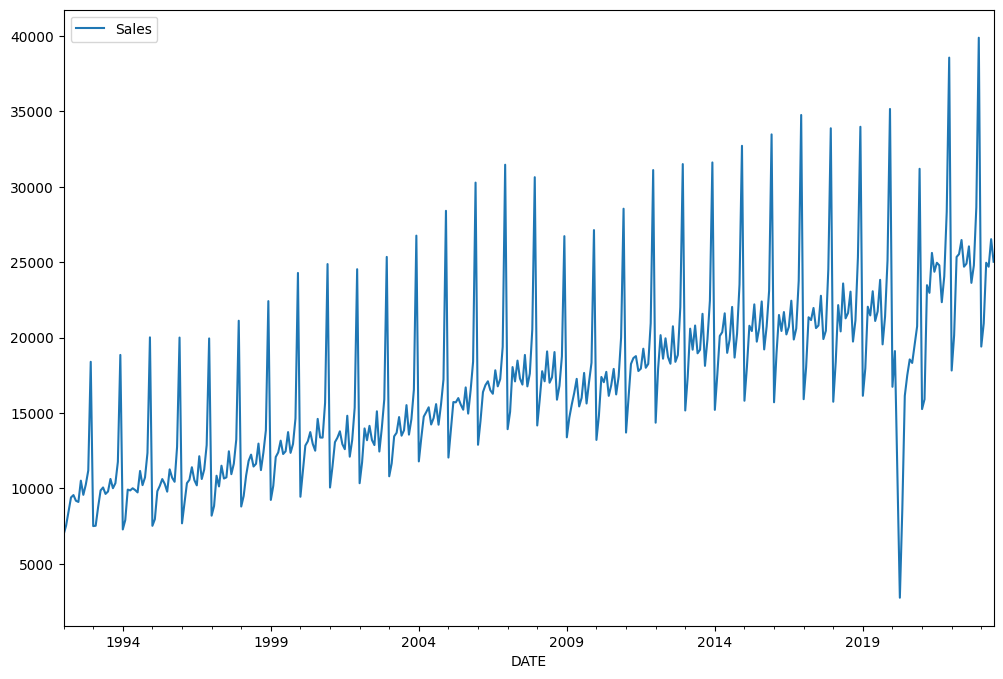

In [4]:
df.plot(figsize=(12,8));

# Train Test Split

In [5]:
len(df)

378

Data is monthly, let's forecast 1.5 years into the future.

In [6]:
len(df)- 18

360

In [7]:
test_size = 18

In [8]:
test_ind = len(df)- test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.head

<bound method NDFrame.head of               Sales
DATE               
1992-01-01   6938.0
1992-02-01   7524.0
1992-03-01   8475.0
1992-04-01   9401.0
1992-05-01   9558.0
...             ...
2021-08-01  24789.0
2021-09-01  22347.0
2021-10-01  24062.0
2021-11-01  28340.0
2021-12-01  38564.0

[360 rows x 1 columns]>

In [10]:
test

,Sales
DATE,
2022-01-01,17817.0
2022-02-01,20152.0
2022-03-01,25347.0
2022-04-01,25539.0
2022-05-01,26470.0
2022-06-01,24701.0
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0


# Normalizing Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:
# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


# Model Creation

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# We're only using one feature in our time series
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20


C:\Users\prath\AppData\Local\Temp\ipykernel_15800\4149840359.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


348/348 [==============================] - 18s 42ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 2/20
348/348 [==============================] - 14s 41ms/step - loss: 0.0134 - val_loss: 0.0061
Epoch 3/20
348/348 [==============================] - 14s 41ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 4/20
348/348 [==============================] - 14s 41ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 5/20
348/348 [==============================] - 14s 41ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 6/20
348/348 [==============================] - 15s 42ms/step - loss: 0.0049 - val_loss: 5.4482e-04
Epoch 7/20
348/348 [==============================] - 22s 62ms/step - loss: 0.0044 - val_loss: 0.0248
Epoch 8/20
348/348 [==============================] - 18s 52ms/step - loss: 0.0052 - val_loss: 0.0010


<Axes: >

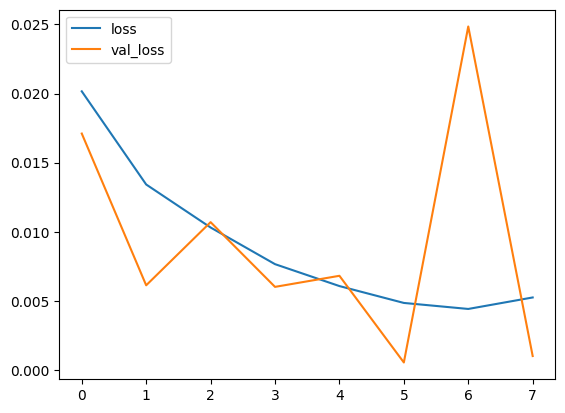

In [17]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# Evaluate on Test Data

In [18]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

print(model.predict(first_eval_batch), scaled_test[0])

1/1 [==============================] - 0s 368ms/step
[[0.4537437]] [0.42066905]


In [19]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

In [21]:
test['Predictions'] = true_predictions

C:\Users\prath\AppData\Local\Temp\ipykernel_15800\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [22]:
test

,Sales,Predictions
DATE,,
2022-01-01,17817.0,19001.469249
2022-02-01,20152.0,19830.104971
2022-03-01,25347.0,24080.432167
2022-04-01,25539.0,23826.722451
2022-05-01,26470.0,26054.274029
2022-06-01,24701.0,25071.432245
2022-07-01,24904.0,25675.329588
2022-08-01,26049.0,25617.103018
2022-09-01,23629.0,23703.733284


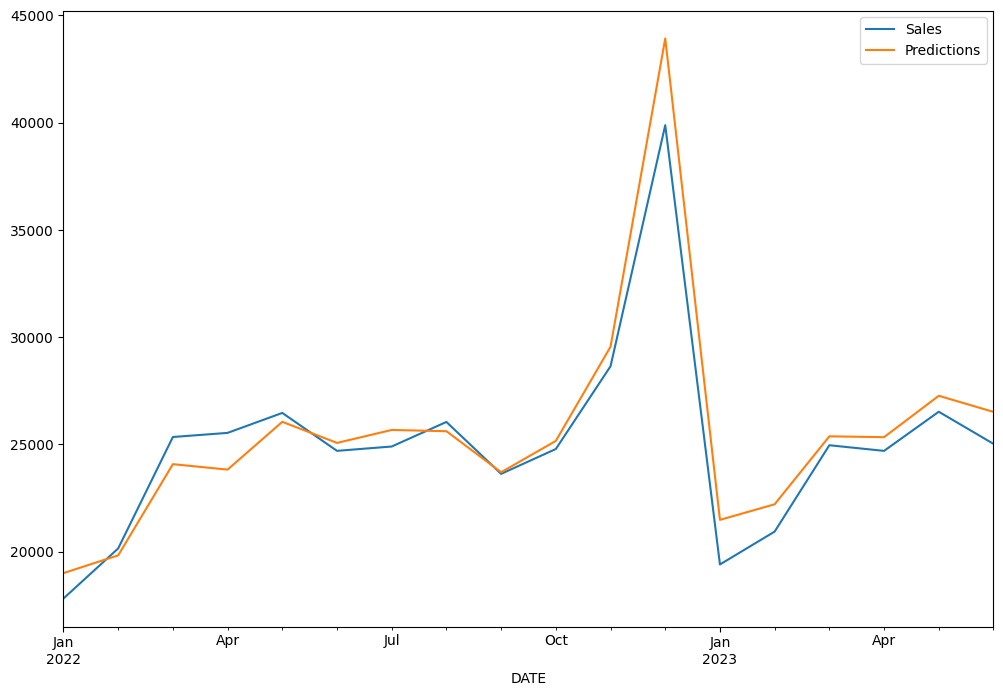

In [23]:
test.plot(figsize=(12,8));

Note this is the prediction we did of the data we know the labels of: now we will do the predictions for the future data

# Retrain and Forecasting

In [24]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [25]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss',patience=2)

# fit model
model.fit(generator,epochs=100, callbacks=[early_stop])

Epoch 1/100


C:\Users\prath\AppData\Local\Temp\ipykernel_15800\2320782080.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=100, callbacks=[early_stop])


366/366 [==============================] - 22s 53ms/step - loss: 0.0192
Epoch 2/100
366/366 [==============================] - 17s 47ms/step - loss: 0.0137
Epoch 3/100
366/366 [==============================] - 18s 48ms/step - loss: 0.0105
Epoch 4/100
366/366 [==============================] - 18s 49ms/step - loss: 0.0066
Epoch 5/100
366/366 [==============================] - 19s 51ms/step - loss: 0.0054
Epoch 6/100
366/366 [==============================] - 15s 42ms/step - loss: 0.0050
Epoch 7/100
366/366 [==============================] - 19s 52ms/step - loss: 0.0044
Epoch 8/100
366/366 [==============================] - 18s 50ms/step - loss: 0.0042
Epoch 9/100
366/366 [==============================] - 19s 52ms/step - loss: 0.0044
Epoch 10/100
366/366 [==============================] - 19s 52ms/step - loss: 0.0037
Epoch 11/100
366/366 [==============================] - 19s 52ms/step - loss: 0.0038
Epoch 12/100
366/366 [==============================] - 19s 51ms/step - loss: 0.0031
E

In [28]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 35ms/step


In [29]:
forecast = scaler.inverse_transform(forecast)

In [31]:
df

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2023-02-01,20937.0
2023-03-01,24963.0
2023-04-01,24700.0


In [30]:
forecast

array([[24412.38423514],
       [25253.89456511],
       [23706.96927977],
       [24437.59554148],
       [27554.20053816],
       [38525.52666283],
       [20324.32213843],
       [21734.46151853],
       [24263.60316133],
       [24304.30498075],
       [25433.71856737],
       [24599.06658363]])

So This is the Sales info that we have forecasted for the year 2024

So now we want to add these values in with the timestamp like 2024-01-01, we can do this by using pandas

In [32]:
forecast_index = pd.date_range(start='2023-07-01',periods=periods,freq='MS')

In [33]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [34]:
forecast_df

,Forecast
2023-07-01,24412.384235
2023-08-01,25253.894565
2023-09-01,23706.969280
2023-10-01,24437.595541
2023-11-01,27554.200538
2023-12-01,38525.526663
2024-01-01,20324.322138
2024-02-01,21734.461519
2024-03-01,24263.603161
2024-04-01,24304.304981


<Axes: >

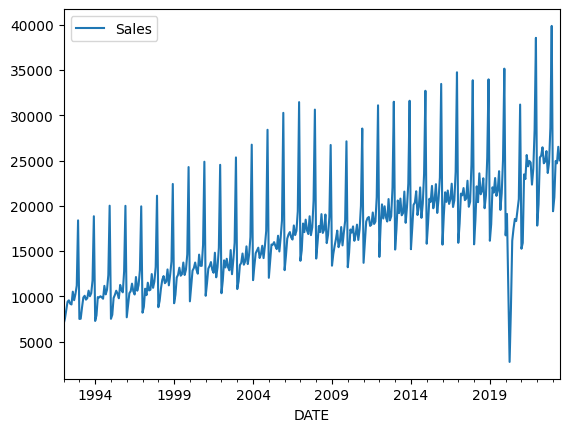

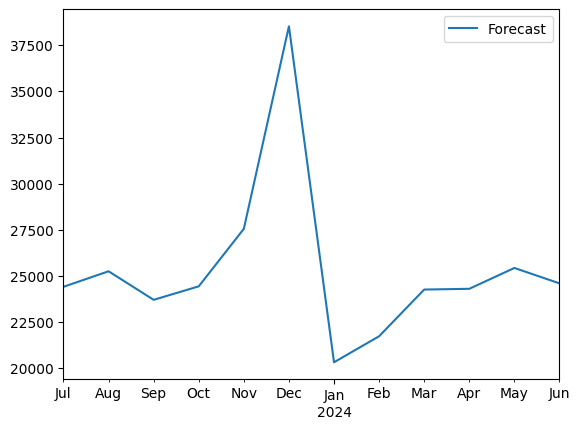

In [35]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

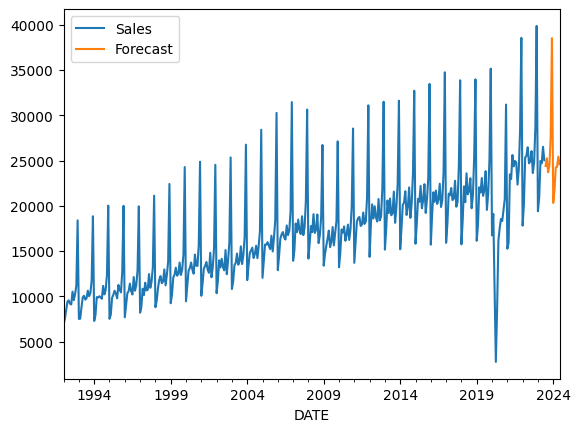

In [36]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

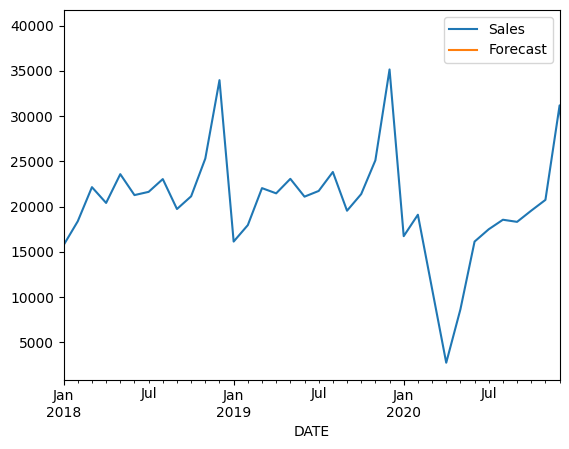

In [37]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')